## Step 1: Problem Identification
Objective:
Predict the selling price of a used car based on its features (year, kilometers driven, fuel type, etc.).

## Step 2: Dataset Acquisition & Exploration

### A. Download the Dataset

* Go to **[Kaggle: Download a real used car dataset](https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset/data)**.

* Download the dataset (`.csv` file[s]) to your working directory (e.g., `./data/`).


### B. Load and Explore the Data

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')



df = pd.read_csv('used_cars.csv')  # Adjust filename as needed
print(df.head())
print(df.info())
print(df.describe())
print(df.columns)


      brand                            model  model_year      milage  \
0      Ford  Utility Police Interceptor Base        2013  51,000 mi.   
1   Hyundai                     Palisade SEL        2021  34,742 mi.   
2     Lexus                    RX 350 RX 350        2022  22,372 mi.   
3  INFINITI                 Q50 Hybrid Sport        2015  88,900 mi.   
4      Audi        Q3 45 S line Premium Plus        2021   9,835 mi.   

       fuel_type                                             engine  \
0  E85 Flex Fuel  300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...   
1       Gasoline                               3.8L V6 24V GDI DOHC   
2       Gasoline                                     3.5 Liter DOHC   
3         Hybrid  354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...   
4       Gasoline                         2.0L I4 16V GDI DOHC Turbo   

        transmission                 ext_col int_col  \
0        6-Speed A/T                   Black   Black   
1  8-Speed Automatic        


## Step 3: Data Preparation

### A. Clean and preprocess columns

- Clean price and mileage columns
- Handle missing values
- Create car age feature
- Optionally, extract horsepower from engine text


In [2]:
import pandas as pd
import numpy as np
import re

# Load data
df = pd.read_csv('used_cars.csv')

# Clean price
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)


# Clean milage
df['milage'] = df['milage'].str.replace(' mi.', '', regex=False)
df['milage'] = df['milage'].str.replace(',', '', regex=False)
df['milage'] = pd.to_numeric(df['milage'], errors='coerce')


# Remove cars with price > $150,000 or mileage > 300,000
df = df[(df['price'] < 150000) & (df['milage'] < 300000)]

# Drop rows with missing price
df = df.dropna(subset=['price'])

# Fill missing categorical values
for col in ['fuel_type', 'clean_title', 'accident']:
    df[col] = df[col].fillna('Unknown')

# Car age
df['car_age'] = 2025 - df['model_year']

# Extract horsepower
def extract_hp(engine_str):
    if pd.isnull(engine_str):
        return np.nan
    match = re.search(r'(\d+(\.\d+)?)HP', engine_str)
    if match:
        return float(match.group(1))
    return np.nan
df['horsepower'] = df['engine'].apply(extract_hp)


# Extract engine size
def extract_engine_size(engine_str):
    if pd.isnull(engine_str):
        return np.nan
    match = re.search(r'(\d+(\.\d+)?)L', engine_str)
    if match:
        return float(match.group(1))
    return np.nan

df['engine_size'] = df['engine'].apply(extract_engine_size)


## Step 4: Encode Categorical Variables

Encode categorical features so they can be used in machine learning models.

In [3]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
categorical_cols = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
for col in categorical_cols:
    df[col] = df[col].astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])

### Correlation Heatmap of Numeric Features

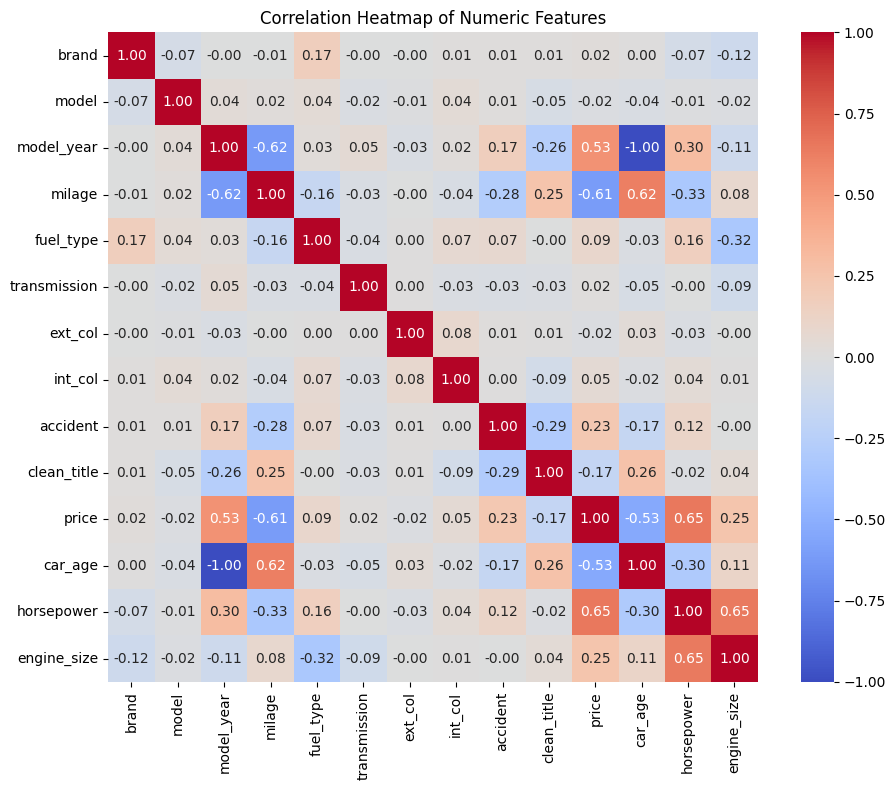

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


## Step 5: Select Features and Target
Choose which columns will be used as features (X) and which as the target (y).

In [6]:
# Select features
features = ['brand', 'model', 'car_age', 'milage', 'fuel_type', 'horsepower','engine_size',
            'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
X = df[features]
y = df['price']



from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]  # Align target with dropped rows
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]


## Step 6: Train-Test Split
Split the data into training and testing sets to evaluate model performance.

In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

#add XGBoost and LightGBM 
try:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(n_estimators=200, random_state=42, verbosity=0)
except ImportError:
    pass

try:
    from lightgbm import LGBMRegressor
    models["LightGBM"] = LGBMRegressor(n_estimators=200, random_state=42, verbose=-1)
except ImportError:
    pass

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# Run cross-validation for each model
for name, model in models.items():
    r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2').mean()
    mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    rmse = (-mse_scores.mean())**0.5  # Convert negative MSE to RMSE
    results[name] = {"R2": r2, "RMSE": rmse}

# Convert results to DataFrame and sort by R2
results_df = pd.DataFrame(results).T.sort_values("R2", ascending=False)
print("Cross-Validation Results:")
print(results_df)

# Choose the best model based on R2
best_model_name = results_df.index[0]
best_model = models[best_model_name]

# Fit best model to training data
best_model.fit(X_train, y_train)

# Predict on test data
y_pred = best_model.predict(X_test)

# Evaluate on test set
print(f"\nBest Model: {best_model_name}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"Test R2: {r2_score(y_test, y_pred):.2f}")


Cross-Validation Results:
                        R2          RMSE
LightGBM          0.865709   9533.739832
XGBoost           0.859942   9740.782812
GradientBoosting  0.832687  10649.214619
RandomForest      0.826785  10836.482212
Ridge             0.639804  15653.035193
Lasso             0.639784  15653.444386
LinearRegression  0.639783  15653.451508

Best Model: LightGBM
Test MAE: 5253.88
Test RMSE: 7892.63
Test R2: 0.89


## Step 7: Feature Importance Visualization
Visualize which features are most important for predicting price.

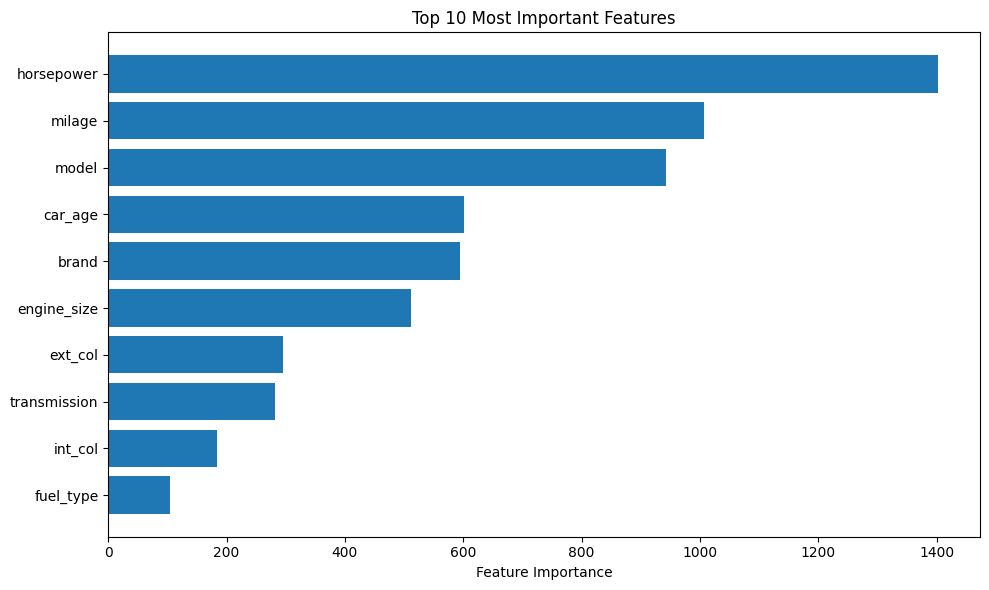

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get importances from the model
importances = best_model.feature_importances_

# Get indices of the top 10 important features (sorted in descending order)
indices = np.argsort(importances)[::-1][:10]

# Get corresponding feature names and importance values
top_features = [features[i] for i in indices]
top_importances = importances[indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_importances[::-1], align='center')
plt.yticks(range(len(top_features)), top_features[::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()


## Step 8: Residual Plot (Diagnostics)
Plot actual vs. predicted prices to visually assess model performance.

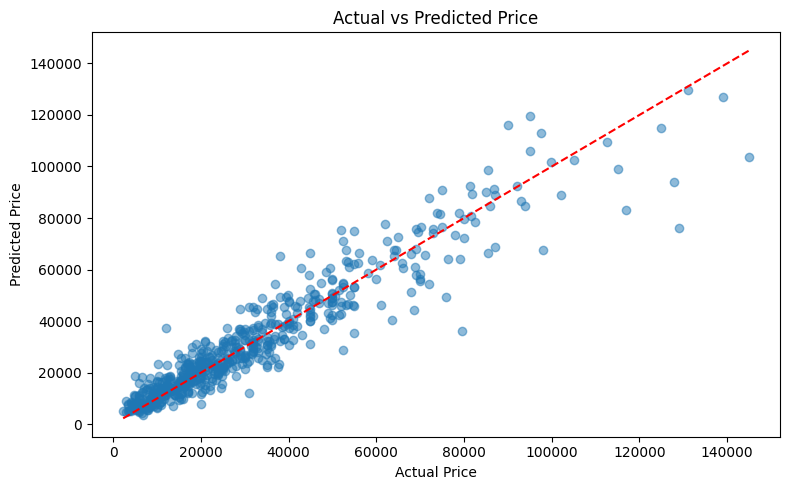

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()
